# Imports

In [ ]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math 
import pylab 

from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_absolute_error
from glob import glob
from os import path
from collections import defaultdict
from virocon import (
    GlobalHierarchicalModel,
    ExponentiatedWeibullDistribution,
    WeibullDistribution,
    DependenceFunction,
    WidthOfIntervalSlicer,
    plot_marginal_quantiles,
    plot_dependence_functions,
    _fitting
)

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

# Data

In [2]:
# Read data

data = pd.read_csv('/Users/lenastroer/Python_Lokal/MasterThese/data_unsorted.csv')
data= data.drop(columns=['Unnamed: 0'])

data_sorted = pd.read_csv('/Users/lenastroer/Python_Lokal/MasterThese/data_sorted.csv')
data_sorted= data_sorted.drop(columns=['Unnamed: 0'])

In [60]:
print(len(data))
print(data)

1272
      windspeed  deflection
0      4.036667      2.7032
1      3.953333      2.7870
2      3.858333      3.6654
3      3.733333      3.7484
4      3.870000      4.8689
...         ...         ...
1267   4.403333      4.7862
1268   3.936667      2.1788
1269   4.578333      3.7424
1270   4.163333      1.4381
1271   4.226667      1.6619

[1272 rows x 2 columns]


# Distributions

In [54]:
# fit GEV and weibull distribution to data
gev_fit = stats.genextreme.fit(data.deflection)
gev_pdf= stats.genextreme.pdf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])
gev_ppf= stats.genextreme.ppf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])
gev_cdf= stats.genextreme.cdf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])

weib_fit = stats.weibull_min.fit(data.deflection)
weib_cdf= stats.weibull_min.cdf(bin_centers, weib_fit[0], loc= weib_fit[1], scale= weib_fit[2])

print(weib_fit)
print(gev_fit)

(1.4377919589122228, 0.6412252681333495, 2.3441938017605053)
(-0.2204844406730722, 1.9963713401349727, 0.9060264390399049)


<IPython.core.display.Javascript object>


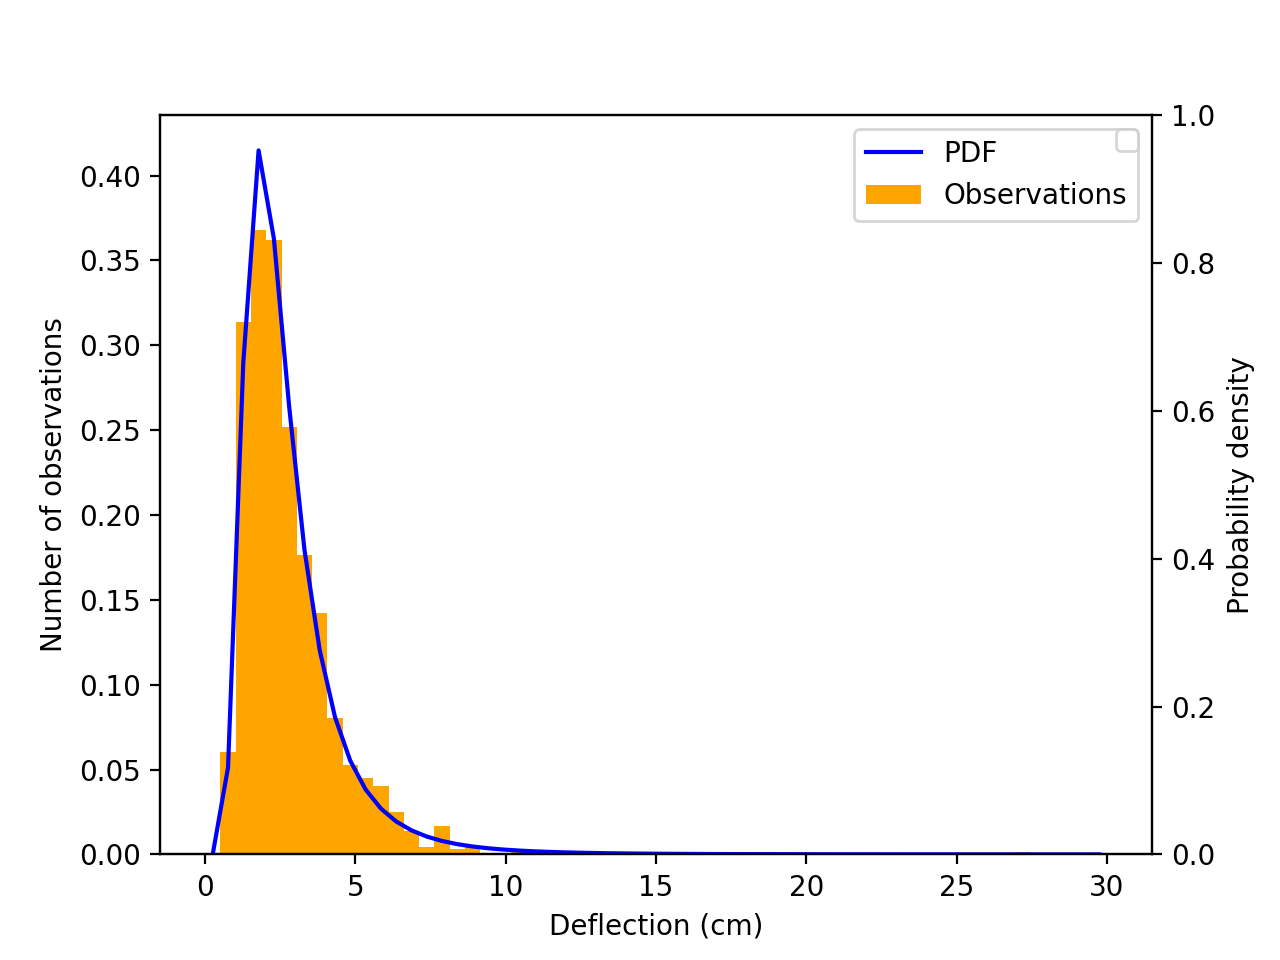

No handles with labels found to put in legend.


In [32]:
# set up the histogramm, 60 steps= bin size of 0,5 cm deflection
bins = np.linspace(0, 30, 60)
bin_centers = 0.5*(bins[1:] + bins[:-1])

fig, ax1 = plt.subplots()

ax1.hist(data.deflection, bins=bins, label='Observations', color='orange', density= 'true')
ax1.plot(bin_centers, gev_pdf, label="PDF", color='b')
ax2 = ax1.twinx()
ax1.set_xlabel('Deflection (cm)')
ax1.set_ylabel('Number of observations')
ax2.set_ylabel('Probability density')

ax1.legend()
ax2.legend()

plt.show()

<IPython.core.display.Javascript object>


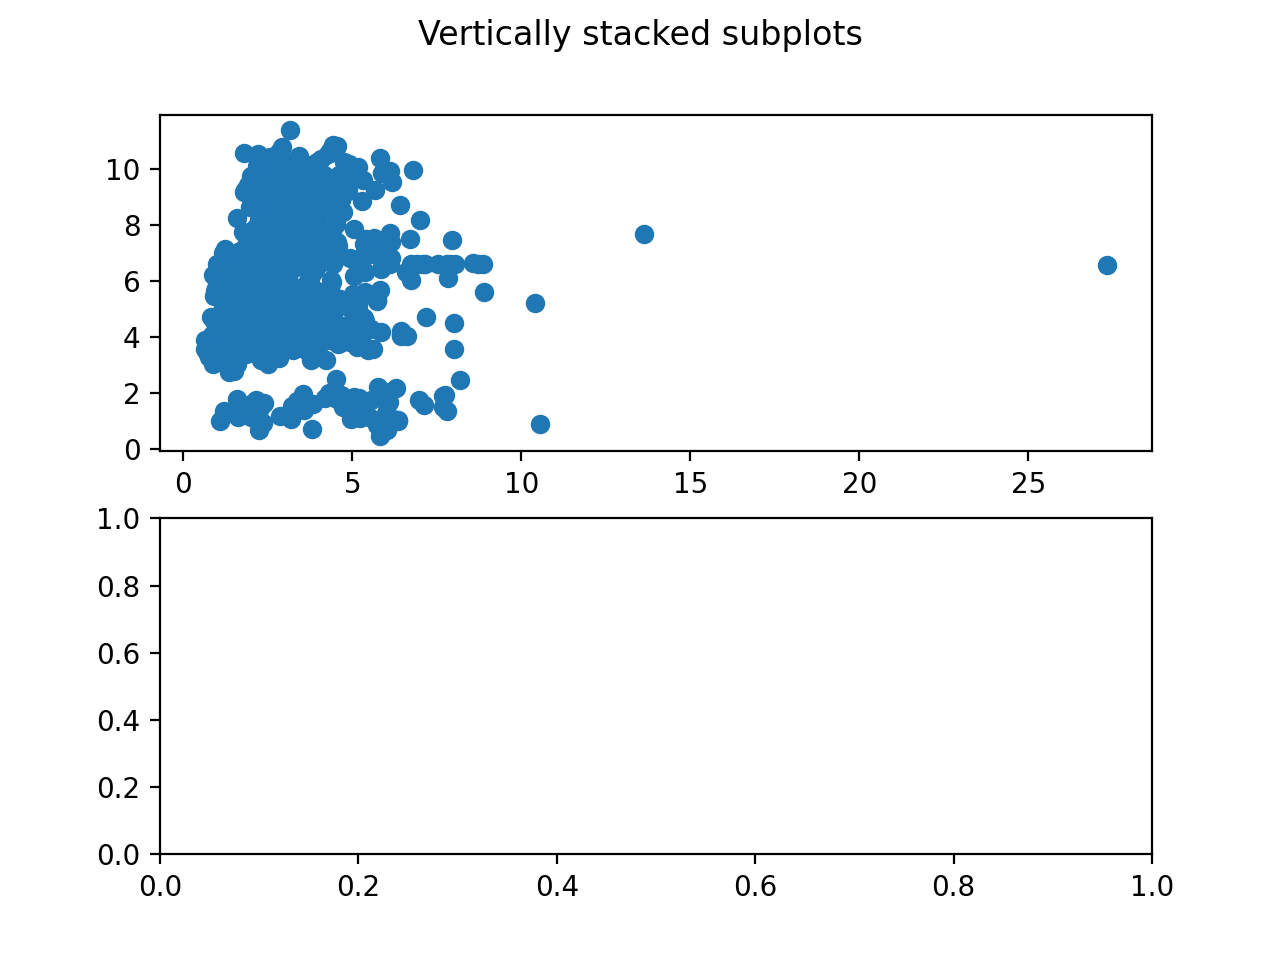

In [159]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
ax1.scatter(data.deflection, data.windspeed)
#ax2.plot(x, -y)

In [55]:
#mean_absolute_error(data.deflection,)

<IPython.core.display.Javascript object>


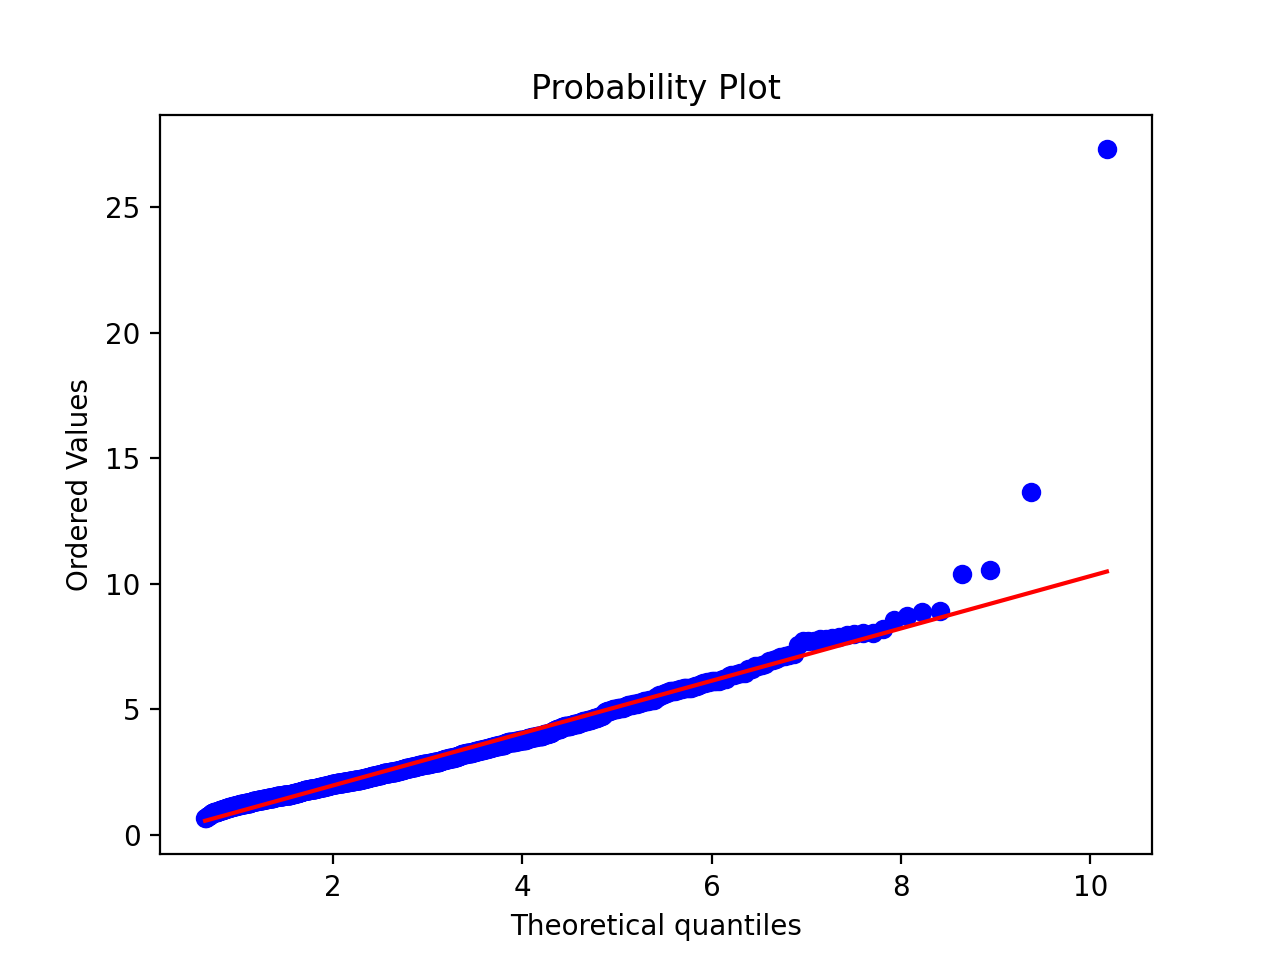

In [8]:
plt.figure()
stats.probplot(data.deflection, (weib_fit[0], weib_fit[1], weib_fit[2]), dist='weibull_min', plot=pylab)
pylab.show()

In [44]:
stats.kstest(data.deflection, weib_cdf, weib_fit)

KstestResult(statistic=0.9709119496855346, pvalue=1.3322676295501878e-15)

<IPython.core.display.Javascript object>


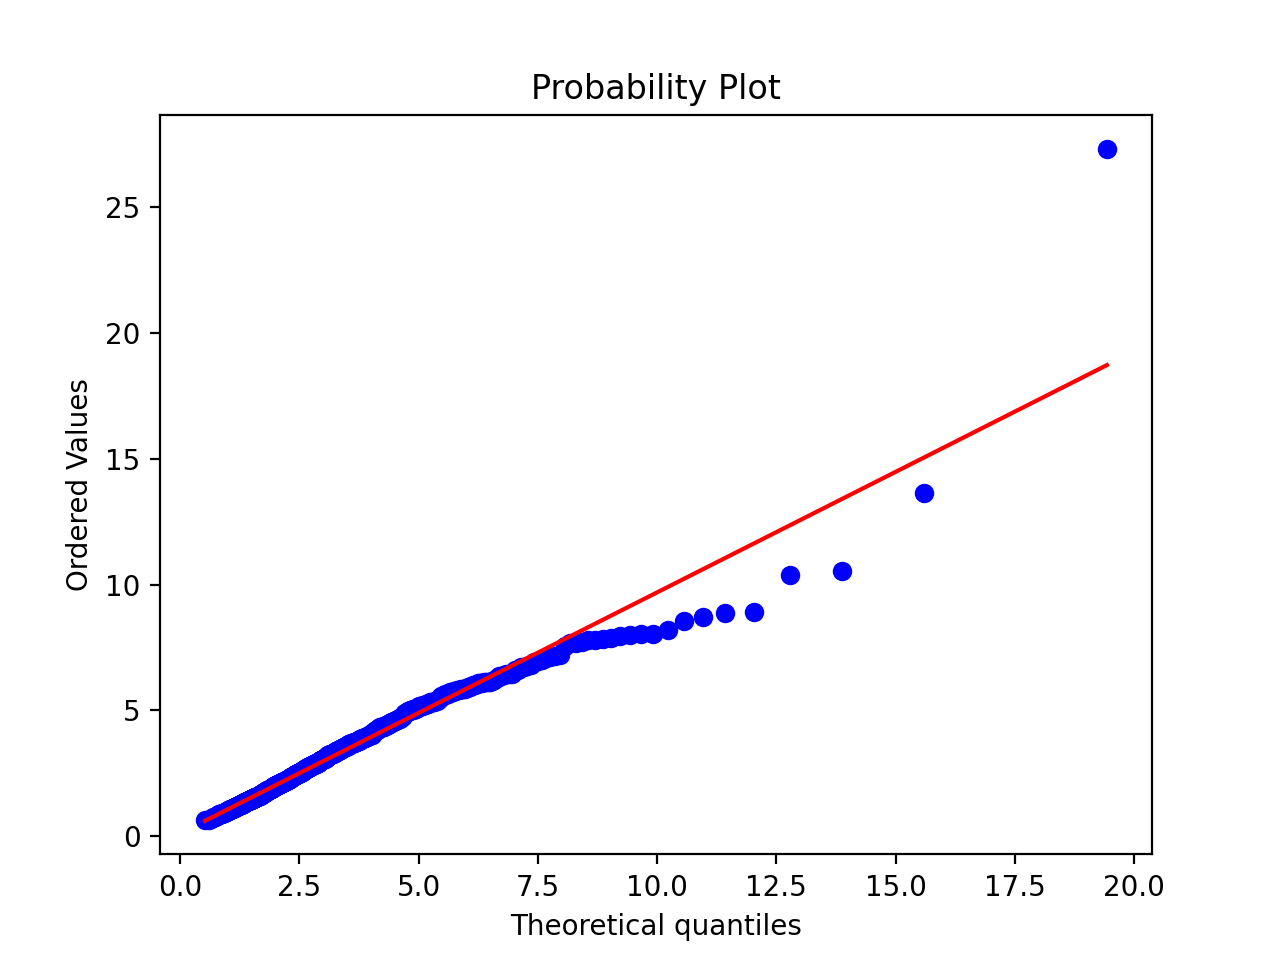

In [9]:
plt.figure()
stats.probplot(data.deflection, (gev_fit[0], gev_fit[1], gev_fit[2]), dist='genextreme', plot=pylab)
pylab.show()

In [46]:
stats.kstest(data.deflection, gev_cdf, gev_fit)

KstestResult(statistic=0.9709119496855346, pvalue=1.3322676295501878e-15)

In [136]:
print(data)

      windspeed  deflection
0      4.036667      2.7032
1      3.953333      2.7870
2      3.858333      3.6654
3      3.733333      3.7484
4      3.870000      4.8689
...         ...         ...
1267   4.403333      4.7862
1268   3.936667      2.1788
1269   4.578333      3.7424
1270   4.163333      1.4381
1271   4.226667      1.6619

[1272 rows x 2 columns]


# Intervals

In [158]:
#deflection_intervals = []

width_slicer = WidthOfIntervalSlicer(width=2, reference="right", min_n_points=1)
wind_slices, wind_references, wind_boundaries = width_slicer.slice_(data.windspeed)

deflection_intervals= []
for i in range (len(wind_references)):
    deflection_intervals.append([])


for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windspeed[j] >= wind_boundaries[i][0]) & (data.windspeed[j] < wind_boundaries[i][1]):
        #if wind_boundaries[i][0] <= data.windspeed[j] < wind_boundaries[i][1]:
        #if data.deflection[j] in range(wind_boundaries[i]):
            deflection_intervals[i].append(data.deflection[j])
            
#print(wind_boundaries)
#print(wind_slices[1])

#deflection_intervals = [data.deflection[slice_] for slice_ in wind_slices]

#for i in range(len(wind_slices)):
    #for j in range(len(wind_slices[i])):
        #if wind_slices[i][j] == True:
            #deflection_intervals[i].append(data.deflection[j])
            #deflection_intervals =[data.deflection[j]]
            #print(data.deflection[j])

#print(deflection_intervals)
print(deflection_intervals[5])
#print(wind_boundaries[1])

[3.1594]


In [83]:
lower_threshold= 0
upper_threshold= 0
n= 0
intervals= []
intervalwidth= 2
timerow_in_interval = []
    
while upper_threshold <= max(data.windspeed):
    lower_threshold = 0 + (intervalwidth * n)
    upper_threshold = intervalwidth+(intervalwidth * n)

    # puts the values of the time series in logical arrays     
    is_low_interval= (data.windspeed >= lower_threshold)
    a= is_low_interval
    is_high_interval= (data.windspeed < upper_threshold)
    b= is_high_interval
    c = np.logical_and(a, b)
    #c= a * b
    #d= bool(c)

    # puts the intervals with the defined length in the output list
    #timerow_in_interval.append(data.deflection[c])
    
         #only puts timerows with more than 5 entries in the interval, to
         #achieve a good representativeness
    
        #if length(timerow_in_interval) > 5:
            #use n+1 if the first interval is included, n when the first is 0
            #either way
            #interval[n+1] = timerow_in_interval
    
    n=n+1


#print(len(c))
print(data.deflection[c])
#print(timerow_in_interval)

275    4.4216
276    5.8108
280    4.0674
283    2.5542
284    2.5664
285    3.9418
286    3.4280
287    4.2879
288    4.9123
289    4.3437
290    3.8559
291    3.1594
292    2.8730
294    3.5190
298    3.4905
300    2.9341
301    3.5341
302    3.4036
321    5.1808
323    2.8218
324    2.1956
330    2.8295
331    2.9239
339    3.9148
341    3.0576
342    1.7990
343    3.2572
344    2.8247
345    4.7433
346    4.5581
347    2.2123
358    2.1890
Name: deflection, dtype: float64


In [66]:
def create_interval(independent_variable, dependent_variable, intervalwidth):
    
    lower_threshold= 0
    upper_threshold= 0
    n= 0
    interval= []
    
    while upper_threshold <= max(dependent_variable):
        lower_threshold = 0 + (intervalwidth * n)
        upper_threshold = intervalwidth+(intervalwidth * n)
    
        # puts the values of the time series in logical arrays     
        is_low_interval= (dependent_variable >= lower_threshold)
        a= is_low_interval
        is_high_interval= (dependent_variable < upper_threshold)
        b= is_high_interval
        c= a * b
        #d= bool(c)
    
        # puts the intervals with the defined length in the output list
        timerow_in_interval= independent_variable(d)
    
         #only puts timerows with more than 5 entries in the interval, to
         #achieve a good representativeness
    
        #if length(timerow_in_interval) > 5:
            #use n+1 if the first interval is included, n when the first is 0
            #either way
            #interval[n+1] = timerow_in_interval
    
        n=n+1
    
    return timerow_in_interval

In [87]:
#intervals= create_interval(data.deflection, data.windspeed, 2)

# Dependence function of response

In [11]:
# Define dependence functions

def _power3(x, a, b, c):
    return a + b * x ** c
def _linear(x, a, b):
    return x * b + a


bounds_3p = [(0, None), (0, None), (None, None)]
bounds_2p = [(None, None), (None, None)]

power3 = DependenceFunction(_power3, bounds_3p, latex="$a + b * x^c$")
linear = DependenceFunction(_linear, bounds_2p, latex="$a + b * x$")

In [12]:
linearfit= linear._fit(data.windspeed, data.deflection)
print(linearfit)

None


# Joint Model

In [13]:
# Wind speed.
dist_description_0 = {
    "distribution": ExponentiatedWeibullDistribution(),
    "intervals": WidthOfIntervalSlicer(2, min_n_points=10),
}
# Deflection.
dist_description_1 = {
    "distribution": WeibullDistribution(),
    "conditional_on": 0,
    "parameters": {"alpha": linear, "beta": linear, "gamma": linear},
}

In [14]:
model = GlobalHierarchicalModel([dist_description_0, dist_description_1])
model.fit(data)
print(model)

GlobalHierarchicalModel(distributions=[ExponentiatedWeibullDistribution(alpha=6.2292216813237244, beta=2.8808699979472103, delta=1.1191451283467646), ConditionalWeibullDistribution(alpha=DependenceFunction(func=_linear, a=0.5314914217861674, b=0.08867837264108916), beta=DependenceFunction(func=_linear, a=0.5314914217861674, b=0.08867837264108916), gamma=DependenceFunction(func=_linear, a=0.5314914217861674, b=0.08867837264108916))], conditional_on=[None, 0])


<IPython.core.display.Javascript object>


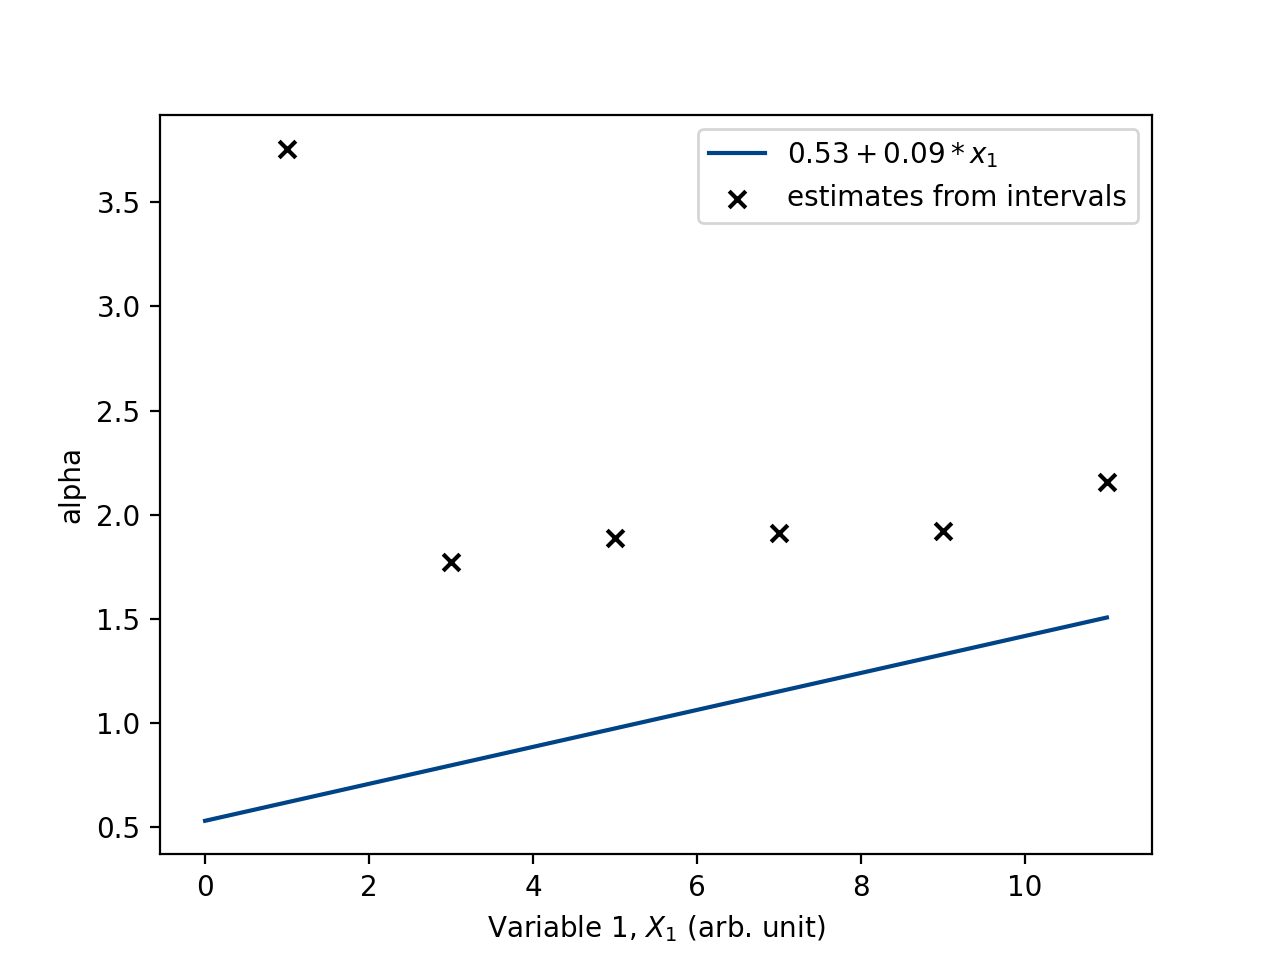

<IPython.core.display.Javascript object>


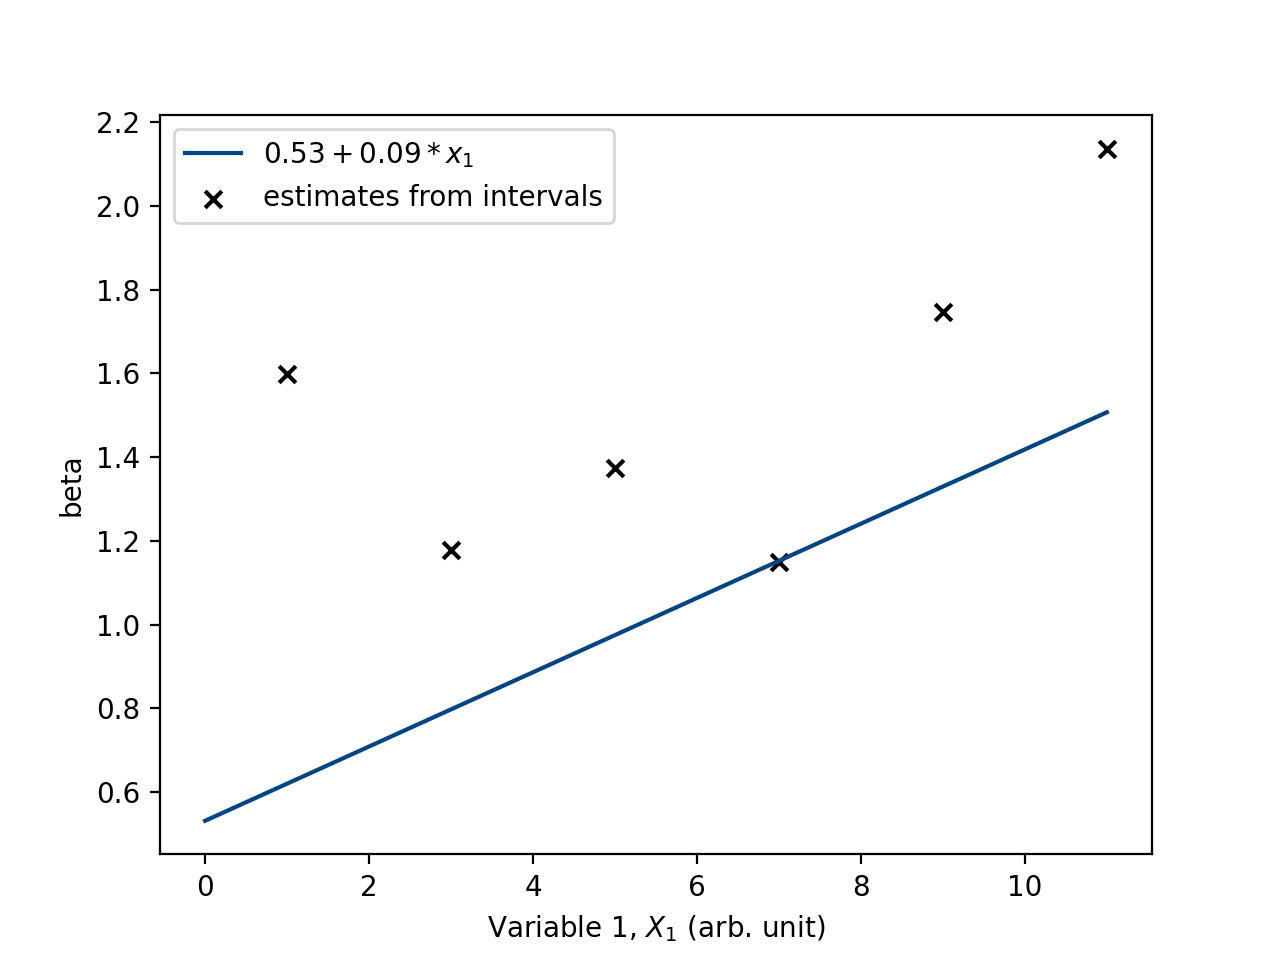

<IPython.core.display.Javascript object>


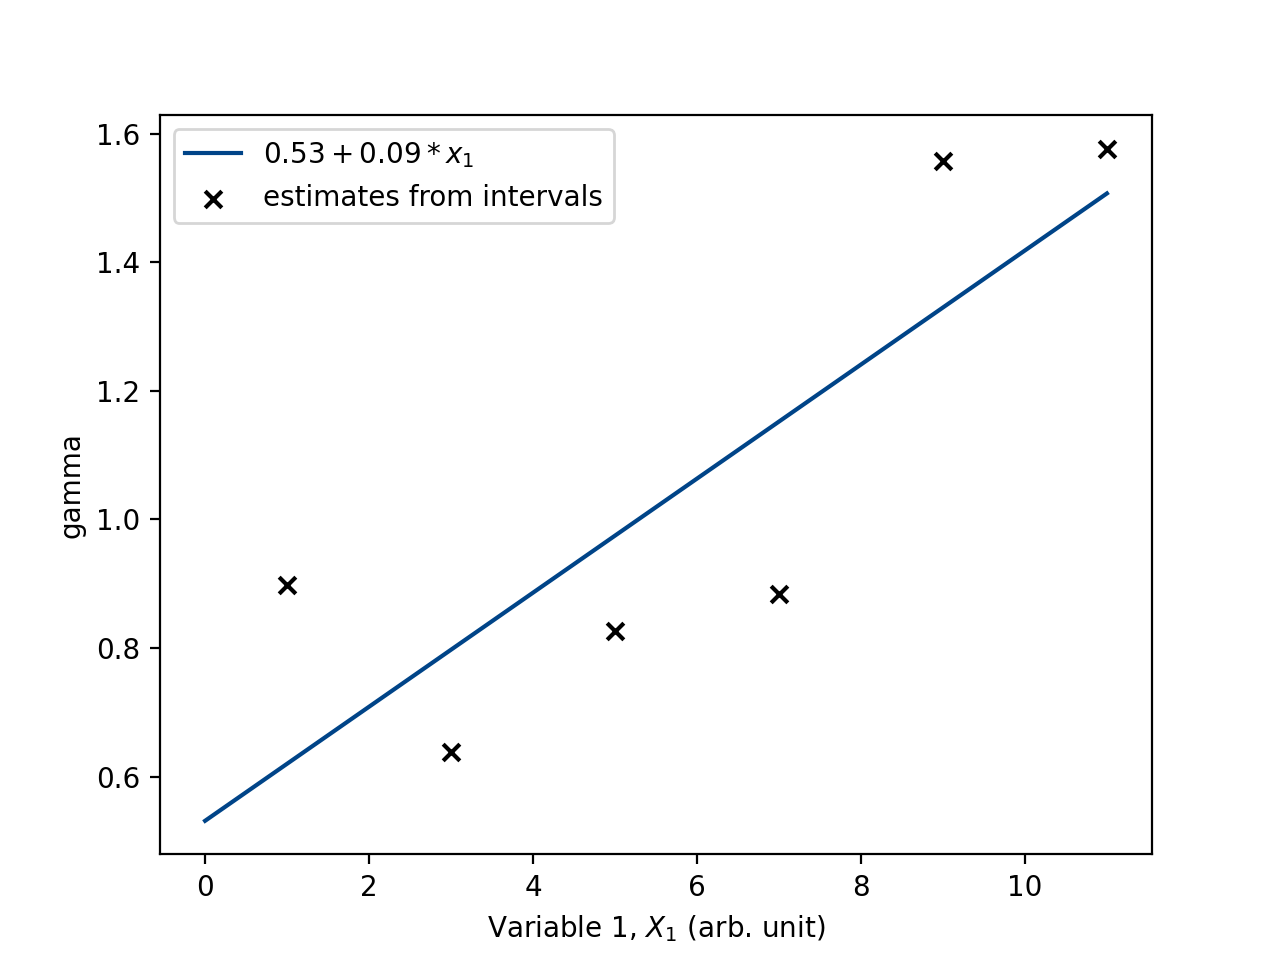

[<AxesSubplot:xlabel='Variable 1, $\\it{X_1}$ (arb. unit)', ylabel='alpha'>,
 <AxesSubplot:xlabel='Variable 1, $\\it{X_1}$ (arb. unit)', ylabel='beta'>,
 <AxesSubplot:xlabel='Variable 1, $\\it{X_1}$ (arb. unit)', ylabel='gamma'>]

In [15]:
plot_dependence_functions(model)

In [16]:
model_sample= model.draw_sample(100)